# Recalibrated Restaurant Rating Based On Sentiment Analysis

<img src="https://static1.squarespace.com/static/5b1590a93c3a53e49c6d280d/t/5fd058bf5efba8153b21ad7f/1607489731350/restaurant-reviews-16x9.jpg?format=1500w" alt="Image Alt Text">

## Project Overview
How important is star rating, or online reviews, for a small business, such as restaurant? 

According to a study, 88% of consumers read online reviews to decide whether to experience or purchase a business' product or service. And, 94% of consumers will not do a business with a company due to negative online reviews. 

Amongst variety of different online review platforms (e.g., Yelp, TripAdvisor, Facebook), Google has the greatest power as it holds ~90% of search traffic. 

Considering the aforementioned facts, it is crucial for a business/company to maintain a positive Google rating for its business to thrive. 

However, Google's star rating system can be arbitrary as reviewers all hold different criteria for providing certain number of stars. In this regard, this project aims to conduct NLP (Natural Language Processing) analysis to determine whether Google's star rating system is relatively accurate/objective based on the sentiment score of each review. 

*Source: Digital Air Strike*

## Business Problem
Google Maps Product Manager received many complaints from restaurant owners that Google rating system is quite inconsistent and arbitrary in that many restaurants are either over or under-rated by its customers despite similar quality of food, atmostphere, and service. 

For this reason, the PM would like to investigate whether the complaints are valid (or substantiated by data). If the claim is true, the PM is considering updating Google Maps' star rating system by auto-assigning stars based on each customer's review instead of user-assigned star rating system. 

To make a data-driven decision, the PM has engaged Sangwon, data scientist, for the analysis.

*Note: This business problem is hypothetical; not based on actual complaint*

## Data Understanding
For this project, Google Maps review dataset was pulled from Google Maps API:

- Each API data pull returns ~300 reviews (5 reviews per restaurant) for a given location (e.g., Chelsea)
- Since the Google Maps API provides random ~300 reviews at a time, there may be duplicates in each pull 
- Since the API only provides the latest 5 reviews per restaurant, the star ratings composition is imbalanced as user has no control over the review selections

Overall, for this project, I have pulled roughly ~5K reviews along with restaurant information to minimize API usage cost and computational power.

In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
# Looking into the file structure
sample_view = pd.read_csv('data/NYC_Restaurants_Reviews.csv')
sample_view.head()

,id,name,address,rating,author,text,review_rating
0,1,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Julia NORTHCOTT,My husband and I went off the tourist track an...,5
1,2,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,dave I,4/13/24 first time here. Cool bar vibe. Intere...,4
2,3,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Daniel Pino,"Layout/atmosphere\n*Bar (old, worn in wood) to...",4
3,4,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,CA Hyde,Stopped by before a show at The Beacon. Good b...,4
4,5,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Steve Dempsey,Not the first time here and it's a good local ...,4


## Data Preparation
Output from the Google Maps API provides quite clean dataset. Hence, we will be doing minimal data cleansing and pre-processing. 

Sentiment analysis model does not require tokenizing, stemming, and lemmatizing as the models rely on pre-built lexicon that contains sentiment scores.

In [3]:
# Merging all data files
file_paths = ['data/NYC_Restaurants_Reviews.csv', 'data/NYC_Restaurants_Reviews_1.csv',
             'data/NYC_Restaurants_Reviews_2.csv', 'data/NYC_Restaurants_Reviews_3.csv',
             'data/NYC_Restaurants_Reviews_4.csv', 'data/NYC_Restaurants_Reviews_5.csv',
              'data/NYC_Restaurants_Reviews_6.csv', 'data/NYC_Restaurants_Reviews_7.csv',
              'data/NYC_Restaurants_Reviews_8.csv', 'data/NYC_Restaurants_Reviews_9.csv',
             'data/NYC_Restaurants_Reviews_10.csv', 'data/NYC_Restaurants_Reviews_11.csv']

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over each file path and read CSV into a DataFrame
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# Print the merged DataFrame
merged_df.head()

,id,name,address,rating,author,text,review_rating
0,1,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Julia NORTHCOTT,My husband and I went off the tourist track an...,5.0
1,2,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,dave I,4/13/24 first time here. Cool bar vibe. Intere...,4.0
2,3,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Daniel Pino,"Layout/atmosphere\n*Bar (old, worn in wood) to...",4.0
3,4,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,CA Hyde,Stopped by before a show at The Beacon. Good b...,4.0
4,5,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Steve Dempsey,Not the first time here and it's a good local ...,4.0


In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2920 non-null   int64  
 1   name           2920 non-null   object 
 2   address        2920 non-null   object 
 3   rating         2920 non-null   object 
 4   author         2919 non-null   object 
 5   text           2909 non-null   object 
 6   review_rating  2919 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 159.8+ KB


In [5]:
# Dropping null values
merged_df = merged_df.dropna()
merged_df.shape

(2909, 7)

In [6]:
# Dropping duplicates in case there are any duplications in the restaurant review data pull
cleaned_df = merged_df.drop_duplicates()
cleaned_df.shape

(2909, 7)

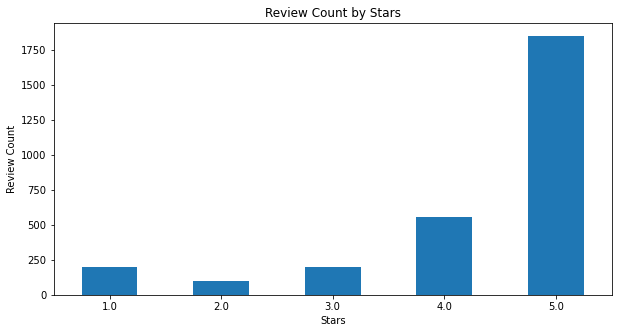

In [7]:
# Star Rating Distribution
cleaned_df['review_rating'].value_counts().sort_index().plot(kind='bar', title='Review Count by Stars', 
                                                             figsize=(10, 5), rot=0)
plt.xlabel('Stars')
plt.ylabel('Review Count');

In [33]:
# Mean, Median, Mode of Star Reviews
mean = round(cleaned_df['review_rating'].mean(),1)
median = cleaned_df['review_rating'].median()

print('Mean star rating for the dataset is:   ', mean)
print('Median star rating for the dataset is: ', median)

Mean star rating for the dataset is:    4.3
Median star rating for the dataset is:  5.0


In [8]:
# Number of unique restaurants
cleaned_df['name'].nunique()

563

In [9]:
# Number of reviewers - there are some who wrote more than one review
cleaned_df['author'].nunique()

2606

## Analysis
For the project, we will be using two different sentiment analysis model:
1. VADER (baseline model)
2. Roberta (model from HuggingFace, which should be more robust)

Both models provide sentiment score for a given review.

### Vader Model

In [15]:
# VADER sentiment analysis model
sia = SentimentIntensityAnalyzer()

In [10]:
# Example of review with emoji - will need special treatment
example = cleaned_df['text'][32]
example

'Attention and friendly service. Spicy mala rice noodle soup is simply so delicious. The soup base was well seasoned with fresh sliced beef, lettuce 🥬, wood ears mushroom, sweet corns, tofu and half of egg cooked in perfection.\n\nA great spot for a quick bite and dishes are in very generous portions and very well priced considering the location.'

In [11]:
# Regular example of review
example2 = cleaned_df['text'][101]
example2

'Love it!  I had Lengua, El Pastor, spicy pork, they all tasted great and authentic street tacos!  I didn’t care about the service, the lady was kinda delayed serving we even without people waiting.  Anyway I was there for the taste and that ain’t changing my desire eating there.'

In [17]:
# Running VADER model for an example review
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.9815}

In [18]:
sia.polarity_scores(example2)

{'neg': 0.028, 'neu': 0.714, 'pos': 0.258, 'compound': 0.9346}

In [35]:
# Checking actual rating of example review
example_rating = cleaned_df['review_rating'][32]
example_rating

5.0

In [36]:
example_rating = cleaned_df['review_rating'][101]
example_rating

5.0

In [ ]:
review_text = {}

for review in cleaned_df['text']:
    d

### Roberta Model

### Clustering

## Conclusion